In [1]:
from rxitect.structs.environment import Environment, Objective
from rxitect.structs.vocabulary import SelfiesVocabulary
from rxitect.models.vanilla.predictor import Predictor
from rxitect import tensor_utils
from rxitect.models.lightning.generator import Generator
from rdkit import Chem
from rxitect import mol_utils

import torch
import selfies as sf

In [2]:
A1_pred = Predictor(path="../models/RF_REG_CHEMBL226.pkg")
A2A_pred = Predictor(path="../models/RF_REG_CHEMBL251.pkg")
ERG_pred = Predictor(path="../models/RF_REG_CHEMBL240.pkg")

In [3]:
mod1 = tensor_utils.ClippedScore(lower_x=4, upper_x=6.5)
mod2 = tensor_utils.ClippedScore(lower_x=9, upper_x=6.5)
mod3 = tensor_utils.ClippedScore(lower_x=7.5, upper_x=5)
no_mod = lambda x: x

In [4]:
A1 = Objective(predictor=A1_pred,
               modifier=mod1,
               threshold=0.99,
               key="A1")
A2A = Objective(predictor=A2A_pred,
                modifier=mod1,
                threshold=0.99,
                key="A2A")
ERG = Objective(predictor=ERG_pred,
                modifier=mod2,
                threshold=0.99,
                key="ERG")

In [5]:
env = Environment([A1, A2A, ERG])

In [6]:
env.get_preds(mols=["CCC", "CC"], is_smiles=True)

,A1,A2A,ERG,DESIRE
0,0.005936,0.000940,1.0,0
1,0.005204,0.001832,1.0,0


In [7]:
env.calc_reward(smiles=["CCC", "CC"], scheme="PR")

array([[0.  ],
       [0.25]])

In [8]:
voc = SelfiesVocabulary("../data/processed/selfies_voc.txt")
gen = Generator(vocabulary=voc)
gen.load_state_dict(torch.load("../models/fine_tuned_selfies_rnn.ckpt")["state_dict"])

<All keys matched successfully>

In [9]:
sampled = gen.sample(50)
dec_sampled = [voc.decode(x) for x in sampled]
smiles = [sf.decoder(x) for x in dec_sampled]

In [10]:
preds = env.get_preds(mols=smiles, is_smiles=True)

In [11]:
desired_idx = preds.query("DESIRE == 1").index

In [12]:
preds["SMILES"] = smiles

In [13]:
desirables = preds.iloc[desired_idx]

In [14]:
smiles_to_plot = desirables["SMILES"].tolist()

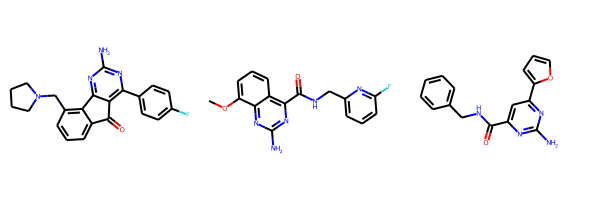

In [15]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in smiles_to_plot])

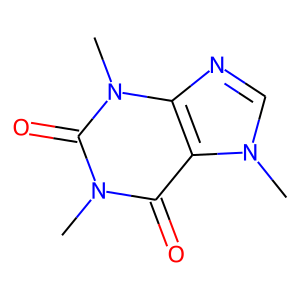

In [16]:
caffeine_smi = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
Chem.Draw.MolToImage(Chem.MolFromSmiles(caffeine_smi))

In [17]:
z = mol_utils.get_fingerprint(Chem.MolFromSmiles(caffeine_smi), fp_type='ECFP6')

In [18]:
smiles_to_plot

['NC1=NC(C2=CC=C(F)C=C2)=C3C(=N1)C4=C(CN5CCCC5)C=CC=C4C3=O',
 'COC1=CC=CC2=C(C(=O)NCC3=CC=CC(F)=N3)N=C(N)N=C12',
 'NC1=NC(C(=O)NCC2=CC=CC=C2)=CC(C3=CC=CO3)=N1']

In [19]:
preds

,A1,A2A,ERG,DESIRE,SMILES
0,0.953733,1.000000,1.000000,0,CCNC(=O)C1OC(N2C=NC3=C(NCC(C4=CC=CC=C4)C5=CC=C...
1,0.576658,0.748715,1.000000,0,CCN1C(=O)C2=C(N=C3N2CCCN3CCC4=CC=C(OCCN5CCOCC5...
2,0.456217,0.504049,1.000000,0,OCC1CCCN(CCCC2CCCC3=CC=C(OCC4=CC=C(C5=CC=CC=C5...
3,0.584045,0.710833,1.000000,0,COC1=CC(N2CCN(C(=O)CN)CC2)=CC=C1NC3=NC=C(Cl)C(...
4,0.449454,0.369420,1.000000,0,CC1=CC=C2C(C3=NN=C(SCCCN4CCC5=CC=6N=COC=6C=C5C...
5,0.309829,0.313326,1.000000,0,CC(=O)NCCC1=CC=CC=C1C2=CC=C(C3CNCCC3C4=CC=C(F)...
6,0.000000,0.000000,1.000000,0,CCCCC1CCN(CCCC(=O)C2=CC=CC=C2C)CC1
7,0.556514,1.000000,1.000000,0,COCC1CCCN1C(=O)C2=CC=C3C(C4=CN=C5C=CC(C#N)=CN4...
8,0.286602,0.337803,1.000000,0,O=C(C=CC1=CC=C2C(=C1)CN(S(=O)(=O)C3=CC=CS3)C2)NO
9,0.549817,0.572774,1.000000,0,CCCOC(=O)C1=C(C2=CC=CC=C2)N=C(CC)C(C(=O)SCCF)=...


In [20]:
env.calc_reward(smiles=smiles, scheme="PR")

array([[0.43617021],
       [0.31914894],
       [0.25531915],
       [0.35106383],
       [0.20212766],
       [0.18085106],
       [0.        ],
       [0.34042553],
       [0.19148936],
       [0.29787234],
       [0.32978723],
       [0.4893617 ],
       [0.23404255],
       [0.46808511],
       [0.0106383 ],
       [0.38297872],
       [0.11702128],
       [0.41489362],
       [0.27659574],
       [0.39361702],
       [0.22340426],
       [0.36170213],
       [0.12765957],
       [0.24468085],
       [0.42553191],
       [0.08510638],
       [0.83333333],
       [0.17021277],
       [0.07446809],
       [0.15957447],
       [0.0212766 ],
       [0.5       ],
       [0.30851064],
       [0.4787234 ],
       [0.45744681],
       [0.44680851],
       [0.06382979],
       [0.37234043],
       [0.05319149],
       [0.10638298],
       [0.28723404],
       [0.66666667],
       [0.14893617],
       [0.40425532],
       [0.13829787],
       [0.21276596],
       [0.09574468],
       [0.042

In [21]:
sf.decoder("[SH2][=Ring1][Cl][B-1][#S][#Branch2][=Se][Si][C-1]")

'[SH2][B-1]#S[C-1]'